# 42577 Introduction to Business Analytics course challenge

Leonardo Debarba Bassani (s232829), Florian Comte (s231816), Natália Pohanková (s231992), Maria do Carmo Barroso Raimundo Lopes Ribeiro (s231900) and Willem Aart Saly (s231806)

In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import math

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import train_test_split

from keras import regularizers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import clone_model

%matplotlib inline

2023-11-27 11:53:22.539124: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Section 1: Introduction, data analysis and visualization

We started our data exploration with looking closely at the data at our hands. The dataset contains **17548339** rows - records of bike rental, and 14 columns. Some of the columns are self-explainatory, some are redundant and some needs to be treated in a way that is possible to work with them further.

There is a column that is unnamed and corresponds with index of a data, so we pressume it is a ride ID, we will be dropping the column.

Description of other columns:
- **tripduration** - in seconds
- **starttime** - start time and date, is a string value, needs to be treated so we get a datetime value
- **stopttime** - end time and date, same as for starttime
- **start_station_id, end_station_id** - unique start/end station indentificator
- **start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude** - position of a start/end station
- **bikeid**
- **usertype** - Customer/Subscriber - again, that is a string value that we need to transform
- **birth_year**
- **gender** - Zero=unknown, 1=male, 2=female - needs transformation

In [2]:
df = pd.read_csv('Trips_2018.csv')

In [3]:
df.head()

,Unnamed: 0,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1
1,1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1
2,2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1
3,3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1
4,4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1


## Data transformation

For the data transformation we dropped the ID column.

In [4]:
df = df.drop(columns=['Unnamed: 0'])

Next we decided to transform the string value of starttime and stopttime to a datetime. 

In [5]:
df.dtypes

tripduration                 int64
starttime                   object
stoptime                    object
start_station_id           float64
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_latitude       float64
end_station_longitude      float64
bikeid                       int64
usertype                    object
birth_year                   int64
gender                       int64
dtype: object

In [6]:
df['starttime'] = pd.to_datetime(df['starttime'], format='%Y-%m-%d %H:%M:%S.%f')
df['stoptime'] = pd.to_datetime(df['stoptime'], format='%Y-%m-%d %H:%M:%S.%f')

Now we can see that the type is no longer object, but datetime. 

In [7]:
df.dtypes

tripduration                        int64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_latitude              float64
end_station_longitude             float64
bikeid                              int64
usertype                           object
birth_year                          int64
gender                              int64
dtype: object

As we already mentioned, columns **usertype** and **gender** are categorical, so we need to transform them. We used **One-Hot Encoding** which helps in handling categorical variables by creating binary columns for each category, with only one of them being "hot" (1) while the others are "cold" (0) for each observation.

In [8]:
df['usertype_customer'] = df['usertype'].map({'Customer': 1, 'Subscriber': 0})
df['usertype_subscriber'] = df['usertype'].map({'Subscriber': 1, 'Customer': 0})

In [9]:
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender,usertype_customer,usertype_subscriber
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,Subscriber,1992,1,0,1
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,Subscriber,1969,1,0,1
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,Subscriber,1956,1,0,1
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,Subscriber,1974,1,0,1
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,Subscriber,1992,1,0,1


Now we can see that the column **usertype** is redundant and we will drop it. Now we will do the same to transform gender column.

In [10]:
df = df.drop(columns=['usertype'])

The **gender** is a bit different, it is already somehow encoded however this is not a good way how to do it. It is possible to compare those values male is less than a female 1<2, or say that female minus male is an unknown so we would like to avoid that to remove any confusion. 

In [11]:
df['gender_unknown'] = df['gender'].map({0: 1, 1: 0, 2: 0})
df['gender_male'] = df['gender'].map({0: 0, 1: 1, 2: 0})
df['gender_female'] = df['gender'].map({0: 0, 1: 0, 2: 1})

In [12]:
df.head()

,tripduration,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,gender,usertype_customer,usertype_subscriber,gender_unknown,gender_male,gender_female
0,970,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1992,1,0,1,0,1,0
1,723,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1969,1,0,1,0,1,0
2,496,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1956,1,0,1,0,1,0
3,306,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1974,1,0,1,0,1,0
4,306,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1992,1,0,1,0,1,0


In [13]:
df = df.drop(columns=['gender'])

We removed id column, and in total added 3 columns so we will just check the shape of the dataframe to be sure that it has 16 columns.

In [14]:
df.shape

(17548339, 16)

After all we decide to change **tripduration** to minutes because we find it more intuitive and easier to interpret. 

In [15]:
df['tripduration_minutes'] = df['tripduration'] / 60
df = df.drop(columns=['tripduration'])

### Missing values, outliers

We need to see whether there are any data that either does not make sence - needs to be deleted due to not reasonable latitude, longitude (outside New York) or impossible journey duration (very long or short). We also checked whether there are any NaN or missing values. 

Firstly we will look at **tripduration_minutes**.

In [16]:
df['tripduration_minutes'].describe().round(2)

count    17548339.00
mean           16.48
std           314.93
min             1.02
25%             5.97
50%            10.08
75%            17.67
max        325167.48
Name: tripduration_minutes, dtype: float64

We can see that the longest duration is for a trip that took 325167.48 minutes which is around 225 days which for a bike ride is completely not imaginable. That prompted us to look at other outliers and remove those to get cleaner data. 

We used a commonly used rule that says a data point is an outlier if it is more than 1.5 x IQR (Interquartile range Q3 - Q1) above the third quartile. 


In [17]:
def get_outliers(column):
    q1, q3 = np.percentile(column, [25, 75])
    iqr = q3 - q1
    upper_bound = q3 + 1.5*iqr
    outliers = df[(column > upper_bound)]
    return upper_bound, outliers

In [18]:
upper_bound, outliers = get_outliers(df['tripduration_minutes'])

In [19]:
print("Upper bound for outliers is ", upper_bound)
outliers['tripduration_minutes'].describe()

Upper bound for outliers is  35.21666666666667


count    824642.000000
mean        110.969507
std        1449.129481
min          35.233333
25%          38.216667
50%          42.500000
75%          54.266667
max      325167.483333
Name: tripduration_minutes, dtype: float64

We can see that majority of the trips that are to be deleted lasts around 50 minutes, but up to more that 1500 minutes. We created a variable for a threshold from where if a trip is longer we would delete the record and we will examine how it works later in assignment. 

In [20]:
OUTLIER_THRESHOLD_MAX = upper_bound

In [21]:
df = df[df['tripduration_minutes'] < OUTLIER_THRESHOLD_MAX]

We checked unreasonably long trips, now we can drop trips that are shorter that 1.5 minutes.

In [22]:
OUTLIER_THRESHOLD_MIN = 1.50

In [23]:
df.shape

(16722369, 16)

For trips that are shorter than 1.5 minutes:

In [24]:
df[df['tripduration_minutes'] < OUTLIER_THRESHOLD_MIN]

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,usertype_customer,usertype_subscriber,gender_unknown,gender_male,gender_female,tripduration_minutes
1527,2018-01-11 11:26:01.666,2018-01-11 11:27:21.717,79.0,40.719116,-74.006667,79.0,40.719116,-74.006667,15444,1970,0,1,0,0,1,1.333333
1633,2018-01-14 12:31:13.543,2018-01-14 12:32:27.231,79.0,40.719116,-74.006667,249.0,40.718710,-74.009001,28488,1977,0,1,0,1,0,1.216667
1649,2018-01-14 18:47:56.465,2018-01-14 18:49:16.097,79.0,40.719116,-74.006667,79.0,40.719116,-74.006667,15420,1966,0,1,0,0,1,1.316667
1676,2018-01-16 09:17:53.099,2018-01-16 09:19:17.870,79.0,40.719116,-74.006667,79.0,40.719116,-74.006667,32891,1960,0,1,0,0,1,1.400000
1710,2018-01-16 17:38:00.458,2018-01-16 17:39:20.669,79.0,40.719116,-74.006667,79.0,40.719116,-74.006667,26138,1977,0,1,0,1,0,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17548025,2018-12-31 20:33:16.342,2018-12-31 20:34:22.582,264.0,40.707065,-74.007319,351.0,40.705310,-74.006126,15105,1999,0,1,0,1,0,1.100000
17548028,2018-12-31 20:35:04.223,2018-12-31 20:36:08.292,351.0,40.705310,-74.006126,264.0,40.707065,-74.007319,32672,1968,0,1,0,1,0,1.066667
17548029,2018-12-31 20:36:30.891,2018-12-31 20:37:39.178,264.0,40.707065,-74.007319,351.0,40.705310,-74.006126,30299,1999,0,1,0,1,0,1.133333
17548032,2018-12-31 20:37:54.877,2018-12-31 20:39:05.334,351.0,40.705310,-74.006126,264.0,40.707065,-74.007319,29988,1968,0,1,0,1,0,1.166667


After removing these, we will check how many records are there left.

In [25]:
df = df[df['tripduration_minutes'] >= OUTLIER_THRESHOLD_MIN]

In [26]:
df.shape

(16610659, 16)

Next we will look at missing values.

In [27]:
df.isna().sum()

starttime                     0
stoptime                      0
start_station_id           2026
start_station_latitude        0
start_station_longitude       0
end_station_id             2026
end_station_latitude          0
end_station_longitude         0
bikeid                        0
birth_year                    0
usertype_customer             0
usertype_subscriber           0
gender_unknown                0
gender_male                   0
gender_female                 0
tripduration_minutes          0
dtype: int64

We learnt that there are some rides - 2026 to be precise, that are missing **start_station_id** and **end_station_id**. 

In [28]:
missing_data = df[df['start_station_id'].isna() & df['end_station_id'].isna()]
missing_data

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,usertype_customer,usertype_subscriber,gender_unknown,gender_male,gender_female,tripduration_minutes
10413697,2018-08-15 11:35:26.014,2018-08-15 12:08:50.036,NaN,40.857,-73.890,NaN,40.857,-73.887,34428,1976,0,1,0,0,1,33.400000
10415434,2018-08-15 12:10:37.436,2018-08-15 12:14:11.292,NaN,40.857,-73.890,NaN,40.857,-73.890,34428,1976,0,1,0,0,1,3.550000
10415668,2018-08-15 12:15:17.333,2018-08-15 12:25:19.762,NaN,40.845,-73.902,NaN,40.857,-73.890,34525,1988,0,1,0,1,0,10.033333
10421216,2018-08-15 13:58:46.212,2018-08-15 14:27:45.173,NaN,40.845,-73.893,NaN,40.839,-73.878,34518,1989,0,1,0,0,1,28.966667
10421276,2018-08-15 13:59:50.331,2018-08-15 14:10:34.866,NaN,40.845,-73.893,NaN,40.842,-73.884,34501,1993,0,1,0,1,0,10.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17390711,2018-12-24 14:22:12.395,2018-12-24 14:32:01.641,NaN,40.863,-73.899,NaN,40.860,-73.905,34463,1986,0,1,0,0,1,9.816667
17393046,2018-12-24 15:34:09.842,2018-12-24 15:40:12.151,NaN,40.860,-73.905,NaN,40.863,-73.902,34463,1986,0,1,0,0,1,6.033333
17393363,2018-12-24 15:44:26.644,2018-12-24 15:49:03.345,NaN,40.863,-73.902,NaN,40.860,-73.902,34463,1986,0,1,0,0,1,4.600000
17423361,2018-12-26 15:08:40.310,2018-12-26 15:19:06.817,NaN,40.860,-73.905,NaN,40.845,-73.914,34463,1991,0,1,0,1,0,10.433333


We can see that that start and end id is missing but latitude and longitude for both is there, so maybe using this information we will be able to fill the NaN values. 

In [29]:
missing_data['start_station_latitude'].value_counts()

start_station_latitude
40.857    374
40.860    353
40.854    281
40.863    271
40.845    161
40.848    160
40.866    138
40.851    132
40.842    108
40.839     29
40.869     19
Name: count, dtype: int64

In [30]:
df[df['start_station_id'].notna() & df['start_station_id'].isin(missing_data['start_station_latitude'])]

,starttime,stoptime,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,birth_year,usertype_customer,usertype_subscriber,gender_unknown,gender_male,gender_female,tripduration_minutes


Looks like it won't be possible and we should just drop them.

In [31]:
df.dropna(inplace=True)

Next we will focus more on stations. We check whether the possition on the map according to latitude, longitude fits areas in New York City. Inspecting the extreme values of the coordinates show a latitude max outside New York, in fact, the latitude is in Canada. The longitude minimal value show values outside New York, in Jersey City.

In [32]:
print('Max latitude start:', df['start_station_latitude'].max())
print('Min latitude start:',df['start_station_latitude'].min())
print('Max longitude start:',df['start_station_longitude'].max())
print('Min longitude start:',df['start_station_longitude'].min())
print('Mean latitude start:',df['start_station_latitude'].mean())
print('Mean longitude start:',df['start_station_longitude'].mean())
print()
print('Max latitude end:', df['end_station_latitude'].max())
print('Min latitude end:',df['end_station_latitude'].min())
print('Max longitude end:',df['end_station_longitude'].max())
print('Min longitude end:',df['end_station_longitude'].min())
print('Mean latitude end:',df['end_station_latitude'].mean())
print('Mean longitude end:',df['end_station_longitude'].mean())


Max latitude start: 45.506364054011385
Min latitude start: 40.64653836709648
Max longitude start: -73.56890559196472
Min longitude start: -74.02535319328308
Mean latitude start: 40.73717771251767
Mean longitude start: -73.98269974016497

Max latitude end: 45.506364054011385
Min latitude end: 40.64653836709648
Max longitude end: -73.56890559196472
Min longitude end: -74.06661093235016
Mean latitude end: 40.73689606117689
Mean longitude end: -73.98291499273188


Using a latitude 41 is a safe cut of value as a scatterplot showed no values in between. It turns out that there are two stations located in Canada that are outside the scope of this assigment. The stations in Jersey City are also outside the scope of the assignment so they are dropped in the same way. 

In [33]:
stations_outside_NY = df[(df['start_station_latitude'] > 41) 
| (df['end_station_latitude'] > 41) 
| (df['start_station_longitude'] < -74.027309) 
| (df['end_station_longitude'] < -74.027309)]

stations_to_drop=np.union1d(stations_outside_NY['start_station_id'].unique(), stations_outside_NY['end_station_id'].unique())
stations_to_drop

array([  79.,  146.,  195.,  257.,  264.,  268.,  276.,  303.,  304.,
        306.,  309.,  315.,  316.,  320.,  327.,  328.,  358.,  363.,
        386.,  415.,  417.,  427.,  514.,  534.,  546., 3183., 3184.,
       3185., 3186., 3192., 3198., 3199., 3203., 3213., 3214., 3256.,
       3267., 3268., 3275., 3276., 3277., 3481., 3488., 3639., 3650.,
       3664., 3681.])

So we drop those stations:

In [34]:
# Drop rows where the 'Station' column matches any value from the list
df = df[~df['start_station_id'].isin(stations_to_drop)]

In [35]:
df = df[~df['end_station_id'].isin(stations_to_drop)]

Last check of the shape, we removed around 2 milion records, so the dataset is now hopefully with less noise that could cause bad predictions.

In [36]:
df.shape

(14934955, 16)

To gain insight in the use per station we make a new list with all the stations and add the number of times it is used in our dataset to show how popular it is. 

In [37]:
startstations = df[['start_station_id', 'start_station_latitude', 'start_station_longitude']].copy() #make a copy of only the colums regarding the startstation
endstations = df[['end_station_id', 'end_station_latitude', 'end_station_longitude']].copy() #make a copy of only the colums regarding the startstation

#give the all the same names
endstations.rename(columns = {'end_station_id':'station'}, inplace = True)
endstations.rename(columns = {'end_station_latitude':'latitude'}, inplace = True)
endstations.rename(columns = {'end_station_longitude':'longitude'}, inplace = True)

startstations.rename(columns = {'start_station_id':'station'}, inplace = True)
startstations.rename(columns = {'start_station_latitude':'latitude'}, inplace = True)
startstations.rename(columns = {'start_station_longitude':'longitude'}, inplace = True)

#combine them into one df
stations=pd.concat([startstations, endstations], axis=0)

#make a new dataframe with the stations and how ofter it is used
stations_use = stations['station'].value_counts().reset_index()
stations_use.columns = ['station', 'count']

#get a list of unique stations
stations.drop_duplicates()

# Combine dataframes based on the common 'ID' column
combined_df = pd.merge(stations_use, stations, on='station', how='inner')
combined_df.drop_duplicates(subset=['station'],inplace=True)
# 'how' parameter specifies the type of join (inner, outer, left, right)
# 'on' parameter specifies the common column to join on
stations_info=combined_df
stations_info.sort_values(by="count",ascending=True,inplace=True)
stations_info

,station,count,latitude,longitude
29869909,3428.0,1,40.740983,-74.001702
29869907,3036.0,2,40.662908,-73.999722
29869904,3250.0,3,40.716910,-73.983838
29869900,428.0,4,40.724677,-73.987834
29869895,3672.0,5,40.669767,-73.994744
...,...,...,...,...
888966,285.0,173255,40.734546,-73.990741
687935,402.0,201031,40.740343,-73.989551
485171,435.0,202764,40.741740,-73.994156
277475,497.0,207696,40.737050,-73.990093


Interestingly, there are 10 stations that are used less then 100 in our dataset. We used Google Streetview to confirm that they are actual stations:

In [38]:
low_use=stations_info[(stations_info['count'] < 100)]
low_use

,station,count,latitude,longitude
29869909,3428.0,1,40.740983,-74.001702
29869907,3036.0,2,40.662908,-73.999722
29869904,3250.0,3,40.716910,-73.983838
29869900,428.0,4,40.724677,-73.987834
29869895,3672.0,5,40.669767,-73.994744
29869884,3487.0,11,40.656596,-74.008493
29869870,3594.0,14,40.666165,-73.959348
29869852,3040.0,18,40.669800,-73.994980
29869815,3245.0,37,40.716444,-73.982331
29869744,3485.0,71,40.725208,-73.974724


The info on the stations shows that the usage is higly skewed:

In [39]:
stations_info[['count']].describe()

,count
count,790.000000
mean,37810.012658
std,36826.788591
min,1.000000
25%,11375.750000
50%,24066.000000
75%,54709.500000
max,277475.000000


To gain insight in the location and use of the stations they are plotted on the map of New York. Manhattan is most densily populated with stations. It is clear that stations in the  centre of Manhattan are used more frequently than other stations:

/var/folders/66/rvdrfgnd27z88q83359qtpmc0000gn/T/ipykernel_51765/241703382.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = matplotlib.cm.get_cmap('plasma')


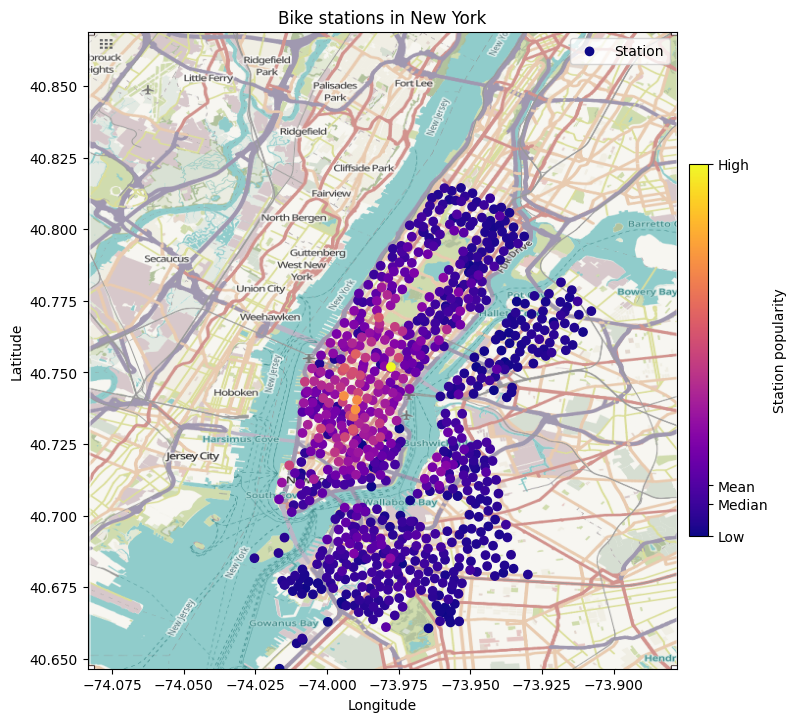

In [40]:
x=stations_info['longitude']
y=stations_info['latitude']
count=stations_info['count']

#cordinates used for the map image:
x_min = -74.0836394
x_max = -73.878
y_min = 40.6465383671
y_max = 40.869
# Load the background image
background_img = mpimg.imread('map.png')

# Create a figure and axis with a fixed size
fig, ax = plt.subplots(figsize=(8, 50))

# Display the background image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max]) 

# Create a colormap based on the 'count' values
colormap = matplotlib.cm.get_cmap('plasma') 

# Create the scatterplot
sc = ax.scatter(x, y, c=count, cmap=colormap, marker='o', label='Station')

# Set axis limits to match the extent of the background image
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Customize the colorbar for the 'count' values
cbar = plt.colorbar(sc,fraction=0.03, pad=0.02)
custom_ticks = [stations_info['count'].min(), stations_info['count'].mean(), stations_info['count'].max(),stations_info['count'].median()  ]  # Adjust these to your desired tick positions
custom_ticklabels = ['Low', 'Mean','High', 'Median']  # Your custom tick labels

cbar.set_ticks(custom_ticks)
cbar.set_ticklabels(custom_ticklabels)
cbar.set_label('Station popularity')


# Customize the plot (labels, title, etc.)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Bike stations in New York')
ax.legend()

# Show the plot
plt.show()

## Data vizualization

The histogram shows the distribution of the trip duration. There is a clear shape recognizable.

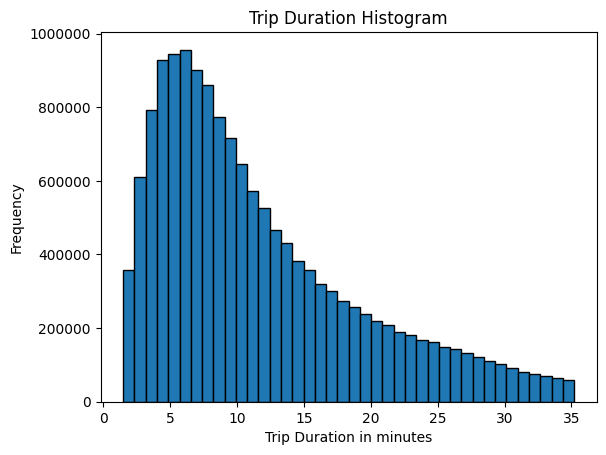

In [41]:
plt.hist(df['tripduration_minutes'], bins=40, edgecolor='k')  
plt.xlabel('Trip Duration in minutes')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

The boxplot shows the number of times a station is used (for start or end). The data is highly skewed. 

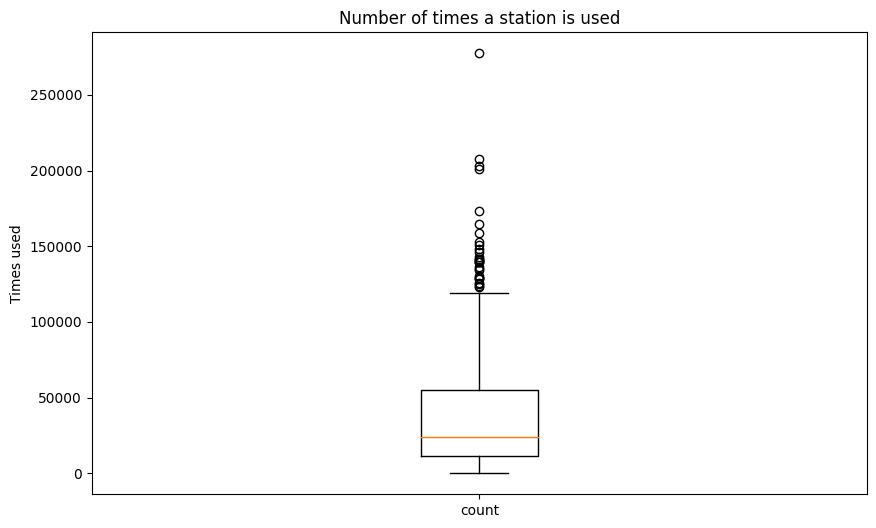

In [42]:
plt.figure(figsize=(10, 6))
plt.boxplot(stations_use['count'])
plt.xticks([1], ['count'])  # Set x-axis label
plt.ylabel('Times used')
plt.title('Number of times a station is used')
plt.show()

Next we were interested in how are bike rentals start spread out during the day and whether there is some kind of pattern. Firstly, we will introduce new column stating the day and whether it is a weekend flag. 

In [43]:
df['weekday'] = df['starttime'].dt.weekday
df['weekend'] = np.where(df['weekday'] >= 5, True, False)

In [44]:
intervals_rush_hour = [(7, 10), (17, 19)]  

In [45]:
def plot_hour_dist():

    plt.figure(figsize=(12, 5))
    plt.hist(df['starttime'].dt.hour, bins=range(0,24), color = "skyblue", ec="k")
    plt.ylabel('Number of rentals')
    plt.xlabel('Hour in a day')
        
    for interval in intervals_rush_hour:
        plt.axvspan(interval[0], interval[1], color='red', alpha=0.2, label=f'{interval[0]} < x < {interval[1]}')
    
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.xticks(np.arange(0, 24, 1.0))
    plt.show()

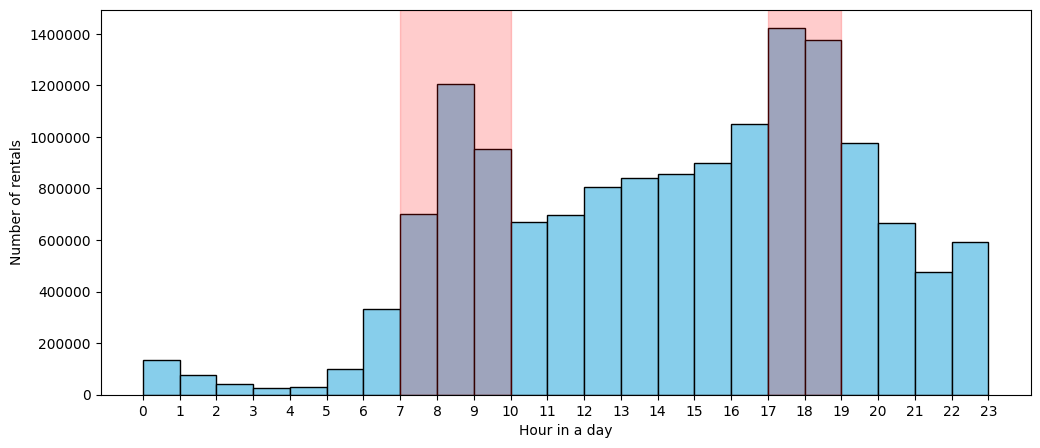

In [46]:
plot_hour_dist()

We can clearly observe the morning and evening rush hour. We were also interested in how rentals are spread out in a month.

In [47]:
import seaborn as sns
import calendar

def hist_month_rentals(month):

    df_month = df[df['starttime'].dt.month == month]
    plt.figure(figsize=(12, 5))
    sns.histplot(data=df, x=df_month['starttime'].dt.day, bins=range(0,31),  hue='weekend', palette=['lightsalmon', 'limegreen'])
    
    plt.ylabel('Number of rentals')
    plt.xlabel('Day in a month')
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.xticks(np.arange(1, 32, 1.0))
    plt.title('Month =  ' + calendar.month_name[month])
    plt.show()

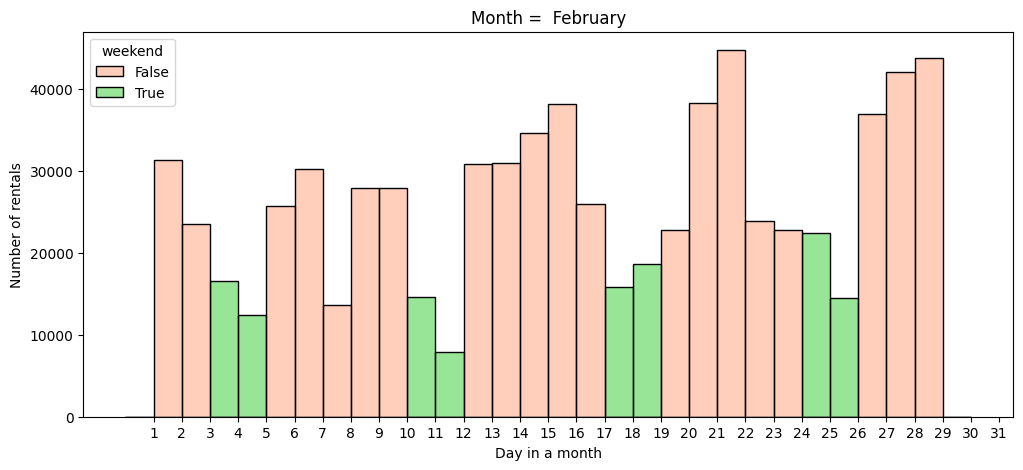

In [48]:
hist_month_rentals(2)

When we use function **hist_month_rentals** we can see how rides are distributed during the specific month. There are obvious differences between weekend and workdays. 

We looked at birth year distribution next.

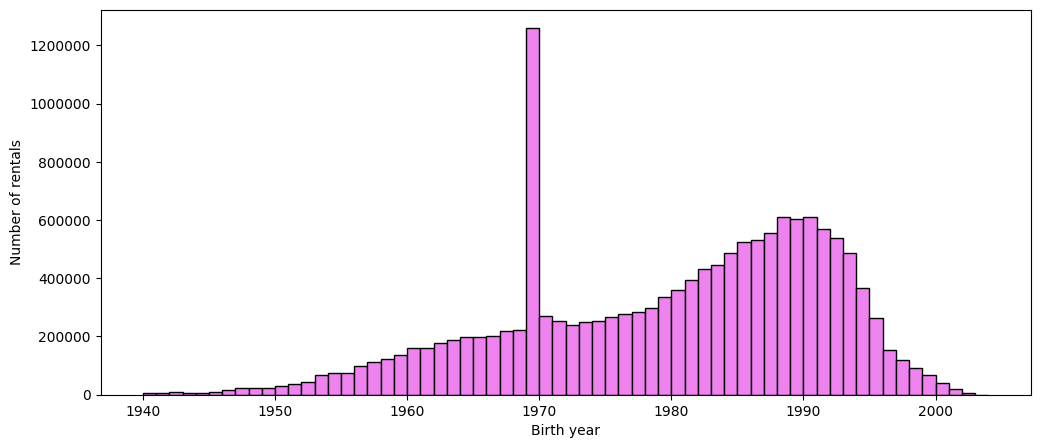

In [49]:
plt.figure(figsize=(12, 5))
plt.hist(df['birth_year'], bins=range(1940, 2005) , color = 'violet', ec="k")
plt.ylabel('Number of rentals')
plt.xlabel('Birth year')
plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

We can observe that year 1969 sticks out, this is because 1969 is the default birth year and apprently a lot of users didn't change it. Because we don't use the birth year in any of our analysis we decided to leave it as it is. We did conclude that they are real users so we don't have to drop them from our dataset.

# Section 2 - Clustering and predicting

## Clusters visualization

First, we need to find out the optimal value of $K$ to know the number of clusters. We can use the elbow plot to evaluate the clusters and then choose the best number of $K$.

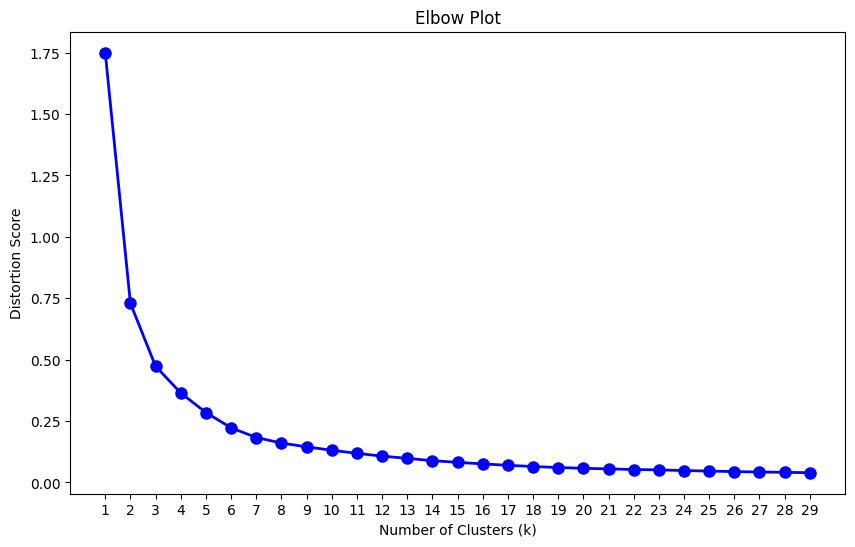

In [50]:
k_vals = range(1,30)
X_clusters = stations_info.drop(columns= ['station', 'count'])
distortion_vals = []

for i in k_vals:
    kmeans_model = KMeans(i, n_init = 10, random_state = 0)
    kmeans_model.fit(X_clusters)
    y_clusters = kmeans_model.predict(X_clusters)

    distortion_vals.append(kmeans_model.inertia_)

# Plot the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(k_vals, distortion_vals, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion Score')
plt.title('Elbow Plot')
plt.xticks(k_vals)
plt.show()

From the graph above, we can see that the 'elbow' value is close to 6 or 7. Because the minimum number of clusters in the assignment is 20, we can set the number of clusters to 20.

We now will find the clusters (using K-Means algorithm) and display them on a plot. The K-Means algorithm is used now because with this algorithm we can control the number of clusters in the map. 

In [51]:
# Create the KMEANS model, fit it and find clusters
model_clusters_kmeans = KMeans(20, random_state=42)
if 'cluster' in stations_info.columns:
    stations_info = stations_info.drop(columns=['cluster'])
X_clusters = stations_info.drop(columns= ['station', 'count'])
model_clusters_kmeans.fit(X_clusters)
y_clusters = model_clusters_kmeans.predict(X_clusters)

# Update station infos to add clusters
stations_info['cluster'] = y_clusters

/Users/Natajda/Desktop/DTU/Business Analytics/business_analytics/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


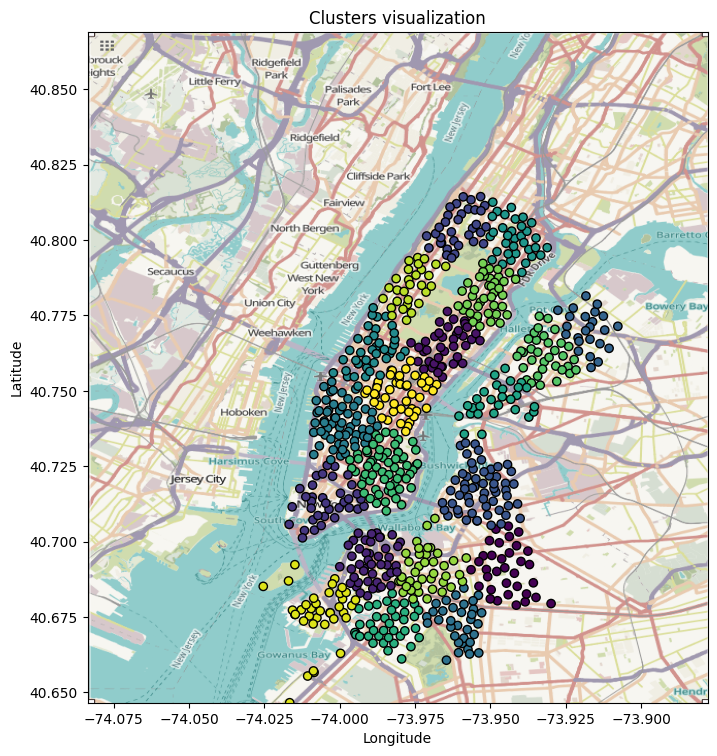

In [52]:
#cordinates used for the map image:
x_min = -74.0836394
x_max = -73.878
y_min = 40.6465383671
y_max = 40.869

# Load the background image
background_img = mpimg.imread('map.png')

# Create a figure and axis with a fixed size
fig, ax = plt.subplots(figsize=(8, 50))

# Display the background image
ax.imshow(background_img, extent=[x_min, x_max,y_min, y_max]) 

# Create the scatterplot
plt.scatter(stations_info['longitude'], stations_info['latitude'], c=stations_info['cluster'], edgecolor='k')

# Set axis limits to match the extent of the background image
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)

# Customize the plot (labels, title, etc.)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Clusters visualization')

# Show the plot
plt.show()

Visually it looks like the algorithm did a good job in clustering the stations in New York. 

## Prediction model for biggest cluster

Before doing prediction part, we will define two utils functions we will need after:

In [53]:
'''
From http://stackoverflow.com/questions/20410312/how-to-create-a-lagged-data-structure-using-pandas-dataframe
Builds a new DataFrame to facilitate regressing over all possible lagged features
'''
def buildLaggedFeatures(s,columns, lag=2,dropna=True):
    if type(s) is pd.DataFrame:
        new_dict={}
        for c in s.columns:
            new_dict[c]=s[c]
        for col_name in columns:
            new_dict[col_name]=s[col_name]
            # create lagged Series
            for l in range(1,lag+1):
                new_dict['%s_lag%d' %(col_name,l)]=s[col_name].shift(l)
        res=pd.DataFrame(new_dict,index=s.index)

    elif type(s) is pd.Series:
        the_range=range(lag+1)
        res=pd.concat([s.shift(i) for i in the_range],axis=1)
        res.columns=['lag_%d' %i for i in the_range]
    else:
        print('Only works for DataFrame or Series')
        return None
    if dropna:
        return res.dropna()
    else:
        return res

In [54]:
# Method to evaluate a regression model by calculating differents scores and find the weight of each feature (if wanted)
# name: name of the tested model
# tested_value: pickups or dropoffs
# X: the features names
# y_test: the original good values
# y_pred: the predicted values by the model
# coefficients: the coefficents for each features
# print_coeffs: True if we want to print the feature importances
def evaluate(name, tested_value, X, y_test, y_pred, coefficients, print_coeffs=True):
    mae_p_lr = mean_absolute_error(y_test, y_pred)
    mse_p_lr = mean_squared_error(y_test, y_pred)
    rmse_p_lr = mean_squared_error(y_test, y_pred, squared=False)
    r2_p_lr = r2_score(y_test, y_pred)

    print(f"{name} for {tested_value}:")
    print(f"Mean Absolute Error (MAE): {mae_p_lr:.4f}")
    print(f"Mean Squared Error (MSE): {mse_p_lr:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse_p_lr:.4f}")
    print(f"R-squared (R^2): {r2_p_lr:.4f}")

    if print_coeffs:
        feature_importance = dict(zip(X.columns, coefficients))
        print("Feature importances: ")
        print(feature_importance)

Now we will try to create a prediction model that, at the end of a day, allows to predict what the demand for a cluster of stations will be over the next 24 hours. For our example, we will use the biggest cluster (but then we will provide method which can do it for any cluster):

In [55]:
# Find the biggest cluster and the stations in
biggest_cluster = stations_info['cluster'].mode().values[0]
stations_in_biggest_cluster = stations_info[stations_info['cluster'] == biggest_cluster]
stations_in_biggest_cluster = stations_in_biggest_cluster.drop(columns=['cluster'])

print(f"The biggest cluster in all year with {stations_in_biggest_cluster.shape[0]} stations is cluster {biggest_cluster}.")

The biggest cluster in all year with 63 stations is cluster 13.


In [56]:
# Extract rows from df with the biggest cluster stations for start and end trips
trips_with_start_in_biggest_cluster = df.merge(stations_in_biggest_cluster, left_on='start_station_id', right_on='station', how='inner')
trips_with_end_in_biggest_cluster = df.merge(stations_in_biggest_cluster, left_on='end_station_id', right_on='station', how='inner')

For this model, we will only need the starttime (for pickups) and stoptime (for dropoffs) to train the model.

In [57]:
# Remove not used columns
start_columns_to_be_removed = ['stoptime', 'start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude',  'end_station_longitude', 'bikeid', 'birth_year', 'usertype_customer',  'usertype_subscriber', 'gender_unknown', 'gender_male', 'gender_female', 'tripduration_minutes', 'weekday', 'station', 'count', 'latitude', 'longitude', 'weekend']
end_columns_to_be_removed = ['starttime', 'start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude',  'end_station_longitude', 'bikeid', 'birth_year', 'usertype_customer',  'usertype_subscriber', 'gender_unknown', 'gender_male', 'gender_female', 'tripduration_minutes', 'weekday', 'station', 'count', 'latitude', 'longitude']

trips_with_start_in_biggest_cluster = trips_with_start_in_biggest_cluster.drop(columns=start_columns_to_be_removed)
trips_with_end_in_biggest_cluster = trips_with_end_in_biggest_cluster.drop(columns= end_columns_to_be_removed)

The next step is to aggregate the data. After this steps, each row of our dataframes will represent a certain time interval (in the example we will take 30min). 

In [58]:
# Aggregate data to a certain interval (here 30T which represents 30mins)
time_interval = '30T'
trips_with_start_in_biggest_cluster = trips_with_start_in_biggest_cluster.groupby(pd.Grouper(key='starttime', freq=time_interval)).size().reset_index(name='count')
trips_with_end_in_biggest_cluster = trips_with_end_in_biggest_cluster.groupby(pd.Grouper(key='stoptime', freq=time_interval)).size().reset_index(name='count')

# Get the month to do the train/test split after
trips_with_start_in_biggest_cluster['month'] = trips_with_start_in_biggest_cluster['starttime'].dt.month
trips_with_end_in_biggest_cluster['month'] = trips_with_end_in_biggest_cluster['stoptime'].dt.month

trips_with_start_in_biggest_cluster['weekday'] = trips_with_start_in_biggest_cluster['starttime'].dt.weekday
trips_with_start_in_biggest_cluster['hour'] = trips_with_start_in_biggest_cluster['starttime'].dt.hour

trips_with_end_in_biggest_cluster['weekday'] = trips_with_end_in_biggest_cluster['stoptime'].dt.weekday
trips_with_end_in_biggest_cluster['hour'] = trips_with_end_in_biggest_cluster['stoptime'].dt.hour

# Drop starttime or stoptime columns
trips_with_start_in_biggest_cluster = trips_with_start_in_biggest_cluster.drop(columns=['starttime'])
trips_with_end_in_biggest_cluster = trips_with_end_in_biggest_cluster.drop(columns=['stoptime'])

We will proceed to incorporate two new columns into the dataset, taking into account the insights gained from data visualization. Specifically, we will introduce boolean columns indicating rush periods and weekends.

In [59]:
print(f"Rush hours are between: {intervals_rush_hour}")

Rush hours are between: [(7, 10), (17, 19)]


In [60]:
trips_with_start_in_biggest_cluster['weekend'] = np.where(trips_with_start_in_biggest_cluster['weekday'] >= 5, True, False)
trips_with_end_in_biggest_cluster['weekend'] = np.where(trips_with_end_in_biggest_cluster['weekday'] >= 5, True, False)

trips_with_start_in_biggest_cluster['rush'] = np.where(
    ((trips_with_start_in_biggest_cluster['hour'] + 1 >= intervals_rush_hour[0][0]) & 
     (trips_with_start_in_biggest_cluster['hour'] + 1 <= intervals_rush_hour[0][1])) | 
    ((trips_with_start_in_biggest_cluster['hour'] + 1 >= intervals_rush_hour[1][0]) & 
     (trips_with_start_in_biggest_cluster['hour'] + 1 <= intervals_rush_hour[1][1])),
    True,
    False
)

trips_with_end_in_biggest_cluster['rush'] = np.where(
    ((trips_with_end_in_biggest_cluster['hour'] + 1 >= intervals_rush_hour[0][0]) & 
     (trips_with_end_in_biggest_cluster['hour'] + 1 <= intervals_rush_hour[0][1])) | 
    ((trips_with_end_in_biggest_cluster['hour'] + 1 >= intervals_rush_hour[1][0]) & 
     (trips_with_end_in_biggest_cluster['hour'] + 1 <= intervals_rush_hour[1][1])),
    True,
    False
)

We will now add lagged features for our prediction models. Since we choosed 30min, it seems logical to take a maximum lag of 48.

In [61]:
# Add some lagged data
trips_with_start_in_biggest_cluster_lagged=buildLaggedFeatures(trips_with_start_in_biggest_cluster, ['count'], lag=48)
trips_with_end_in_biggest_cluster_lagged=buildLaggedFeatures(trips_with_end_in_biggest_cluster, ['count'], lag=48)

Normalization or standardization is typically applied when dealing with numerical features on different scales. In this case, since we are dealing with counts and booleans that already have a consistent interpretation, there is no need for additional normalization or standardization procedures.

In [62]:
# Split data to train/test
training_pickup = trips_with_start_in_biggest_cluster_lagged[trips_with_start_in_biggest_cluster_lagged['month'] <= 10]
testing_pickup = trips_with_start_in_biggest_cluster_lagged[trips_with_start_in_biggest_cluster_lagged['month'] > 10]

training_dropoffs = trips_with_end_in_biggest_cluster_lagged[trips_with_end_in_biggest_cluster_lagged['month'] <= 10]
testing_dropoffs = trips_with_end_in_biggest_cluster_lagged[trips_with_end_in_biggest_cluster_lagged['month'] > 10]

x_training_pickup = training_pickup.drop(['count', 'month', 'hour', 'weekday'], axis = 1)
y_training_pickup = training_pickup['count']

x_testing_pickup = testing_pickup.drop(['count', 'month', 'hour', 'weekday'], axis = 1)
y_testing_pickup = testing_pickup['count']

x_training_dropoffs = training_dropoffs.drop(['count', 'month', 'hour', 'weekday'], axis = 1)
y_training_dropoffs = training_dropoffs['count']

x_testing_dropoffs = testing_dropoffs.drop(['count', 'month', 'hour', 'weekday'], axis = 1)
y_testing_dropoffs = testing_dropoffs['count']

Now we will train differents models and evaluate their performance:

In [63]:
# Linear Regression
model_lr_p = LinearRegression()
model_lr_p.fit(x_training_pickup, y_training_pickup)
y_pred_p_lr = model_lr_p.predict(x_testing_pickup)

model_lr_d = LinearRegression()
model_lr_d.fit(x_training_dropoffs, y_training_dropoffs)
y_pred_d_lr = model_lr_d.predict(x_testing_dropoffs)

evaluate("Linear Regression", "pickups", x_testing_pickup, y_testing_pickup, y_pred_p_lr, 0, False)
print("")
evaluate("Linear Regression", "dropoffs", x_testing_dropoffs, y_testing_dropoffs, y_pred_d_lr, 0, False)

Linear Regression for pickups:
Mean Absolute Error (MAE): 17.8108
Mean Squared Error (MSE): 702.5878
Root Mean Squared Error (RMSE): 26.5064
R-squared (R^2): 0.9073

Linear Regression for dropoffs:
Mean Absolute Error (MAE): 14.6924
Mean Squared Error (MSE): 426.0740
Root Mean Squared Error (RMSE): 20.6416
R-squared (R^2): 0.9419


In [64]:
# SVR
model_svr_p = SVR()
model_svr_p.fit(x_training_pickup, y_training_pickup)
y_pred_p_svr = model_svr_p.predict(x_testing_pickup)

model_svr_d = SVR()
model_svr_d.fit(x_training_dropoffs, y_training_dropoffs)
y_pred_d_svr = model_svr_d.predict(x_testing_dropoffs)

evaluate("SVR", "pickups", x_testing_pickup, y_testing_pickup, y_pred_p_svr, 0, False)
print("")
evaluate("SVR", "dropoffs", x_testing_dropoffs, y_testing_dropoffs, y_pred_d_svr, 0, False)

SVR for pickups:
Mean Absolute Error (MAE): 20.8641
Mean Squared Error (MSE): 1123.8231
Root Mean Squared Error (RMSE): 33.5235
R-squared (R^2): 0.8517

SVR for dropoffs:
Mean Absolute Error (MAE): 18.7610
Mean Squared Error (MSE): 825.7162
Root Mean Squared Error (RMSE): 28.7353
R-squared (R^2): 0.8874


In [65]:
# Decision Tree Regressor
model_dt_p = DecisionTreeRegressor(random_state=42)
model_dt_p.fit(x_training_pickup, y_training_pickup)
y_pred_p_dt = model_dt_p.predict(x_testing_pickup)

model_dt_d = DecisionTreeRegressor(random_state=42)
model_dt_d.fit(x_training_dropoffs, y_training_dropoffs)
y_pred_d_dt = model_dt_d.predict(x_testing_dropoffs)

evaluate("Decision Tree Regressor", "pickups", x_testing_pickup, y_testing_pickup, y_pred_p_dt, 0, False)
print("")
evaluate("Decision Tree Regressor", "dropoffs", x_testing_dropoffs, y_testing_dropoffs, y_pred_d_dt, 0, False)

Decision Tree Regressor for pickups:
Mean Absolute Error (MAE): 17.7653
Mean Squared Error (MSE): 713.2733
Root Mean Squared Error (RMSE): 26.7072
R-squared (R^2): 0.9059

Decision Tree Regressor for dropoffs:
Mean Absolute Error (MAE): 17.6503
Mean Squared Error (MSE): 740.7527
Root Mean Squared Error (RMSE): 27.2168
R-squared (R^2): 0.8990


Based on the metrics, we conclude that the performance of Linear Regression and Decision Tree Regressor for predicting pick-ups are very similar and close, but Linear Regression outperforms all others in predicting drop offs. 

Now that you described the detailed process, we will introduce two functions to train a model and then predict the next day for a certain cluster:

In [66]:
# model: Model you want to use (Linear Regression, ...)
# cluster: Number of the cluster we want to analyze
# is_for_pickups: you want to analyze pickups or not (if not then it will analyze dropoffs)
# time_interval: the time we want for aggregation interval (in minutes)
def train_model(model, cluster, is_for_pickups, time_interval=30):
    stations = stations_info[stations_info['cluster'] == cluster]
    stations = stations.drop(columns=['cluster'])
    inner_left = 'start_station_id' if is_for_pickups else 'end_station_id'
    trips = df.merge(stations, left_on=inner_left, right_on='station', how='inner')

    time_to_be_removed = 'stoptime' if is_for_pickups else 'starttime'
    time_to_not_be_removed = 'starttime' if is_for_pickups else 'stoptime'
    
    columns_to_be_removed = [time_to_be_removed, 'start_station_id', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_latitude',  'end_station_longitude', 'bikeid', 'birth_year', 'usertype_customer',  'usertype_subscriber', 'gender_unknown', 'gender_male', 'gender_female', 'tripduration_minutes', 'weekday', 'weekend', 'station', 'count', 'latitude', 'longitude']
    trips = trips.drop(columns=columns_to_be_removed)
    trips[time_to_not_be_removed] = pd.to_datetime(trips[time_to_not_be_removed])

    trips = trips.groupby(pd.Grouper(key=time_to_not_be_removed, freq=str(time_interval) + 'T')).size().reset_index(name='count')
    trips['month'] = trips[time_to_not_be_removed].dt.month
    trips['weekday'] = trips[time_to_not_be_removed].dt.weekday
    trips['hour'] = trips[time_to_not_be_removed].dt.hour

    trips = trips.drop(columns=[time_to_not_be_removed])

    trips['weekend'] = np.where(trips['weekday'] >= 5, True, False)

    trips['rush'] = np.where(
        ((trips['hour'] + 1 >= intervals_rush_hour[0][0]) & 
        (trips['hour'] + 1 <= intervals_rush_hour[0][1])) | 
        ((trips['hour'] + 1 >= intervals_rush_hour[1][0]) & 
        (trips['hour'] + 1 <= intervals_rush_hour[1][1])),
        True,
        False
    )

    trips=buildLaggedFeatures(trips, ['count'], lag=int((60*24)/time_interval))

    training = trips[trips['month'] <= 10]
    testing = trips[trips['month'] > 10]

    training = training.drop(columns=['month', 'hour', 'weekday'])
    testing = testing.drop(columns=['month', 'hour', 'weekday'])

    x_training = training.drop('count', axis = 1)
    y_training = training['count']

    x_testing = testing.drop('count', axis = 1)
    y_testing = testing['count']

    model.fit(x_training, y_training)
    y_pred = model.predict(x_testing)

    r2_p_lr = r2_score(y_testing, y_pred)

    return r2_p_lr, model

# model: Model you previously trained
# weekend: True if the day you are predicting is a week end day
# previous_day_data: data of the previous day pickups/dropoffs (the size can varies depending on the time_interval parameter during training)
def predict_next_day(model, week_end, previous_day_data):
    predictions = []
    columns = ['weekend', 'rush'] + [f'count_lag{i}' for i in range(1, len(previous_day_data) + 1)]

    x = pd.DataFrame(columns=columns)
    x.loc[0] = [week_end, False] + previous_day_data

    hour_counter = 0

    for i in range(len(previous_day_data)):
        prediction = model.predict(x)
        predictions.append(prediction[0])

        previous_day_data = pd.Series(previous_day_data).shift(-1).fillna(int(prediction[0]))

        x.loc[0] = [week_end, (hour_counter + 1 >= intervals_rush_hour[0][0] and hour_counter + 1 <= intervals_rush_hour[0][1]) or (hour_counter + 1 >= intervals_rush_hour[1][0] and hour_counter + 1 <= intervals_rush_hour[1][1])] + previous_day_data.tolist()

    return predictions

In [67]:
# Example of usage of previously gave functions (with fake data)
r2, m = train_model(cluster=13, is_for_pickups=True, model=LinearRegression(), time_interval=30)
print(f"R-squared (R^2) of your model: {r2:.4f}")
print("Pickups predictions for the next day (fake data) :")
print(predict_next_day(model=m, week_end=True, previous_day_data=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]))

R-squared (R^2) of your model: 0.9073
Pickups predictions for the next day (fake data) :
[2.2056759999013376, 5.293803009410749, 0.21246336253674736, 1.7704007759244926, 3.8515894870309704, 3.011589924767881, 4.619653412129577, 4.34204484433325, 5.160205447067922, 6.1589278235042535, 8.357119284987483, 8.122707225561703, 10.23331296421342, 10.527506554385774, 12.17915681789672, 11.67099612905636, 13.336326923100337, 13.73740082233549, 14.938854735902783, 15.550172873853553, 18.33399172098668, 16.98947379149084, 21.29683501186553, 26.820696698624626, 1.0803198940515188, 6.302010078519778, 0.008928835419542924, 1.97269133082342, 3.6150681468836976, 2.72729448368496, 5.109970527390477, 4.011654133302562, 5.403909283251976, 6.238844450964558, 8.005377590033074, 8.080995809672489, 10.607544563288437, 10.16827856675787, 12.519541728022626, 11.638502515946353, 13.476101615481076, 13.654031456921624, 15.116279470060327, 15.07035087927846, 18.839855108478325, 17.052250443155007, 21.315260193245

The function returns the predicted demand for the next day for every 30 minutes. It is just an example of how to use it and the previous date data is random.

## Prediction of next day demand of bikes

First we create a function to predict the bikes we need based on the maximum difference of each interval.

In [68]:
# Predict how many bikes we should put for a cluster for the next day
# cluster: cluster we want to predict
# pickups_model: model we want to use for pickups
# dropouts_model: model we want to use for dropouts
# previous_day_pickups_data: the data for the pickups of the previous day we want to calculate 
# previous_day_dropouts_data: the data for the dropouts of the previous day we want to calculate 
def predict_manually_repositions(cluster, pickups_model, dropouts_model, week_end, previous_day_pickups_data, previous_day_dropouts_data):
    r2_p, m_pickups = train_model(cluster=cluster, is_for_pickups=True, model=pickups_model, time_interval=(24 * 60) / len(previous_day_pickups_data))
    r2_d, m_dropouts = train_model(cluster=cluster, is_for_pickups=False, model=dropouts_model, time_interval=(24 * 60) / len(previous_day_dropouts_data))

    next_24h_pickups_prediction = predict_next_day(model=m_pickups, week_end=week_end, previous_day_data=previous_day_pickups_data)
    next_24h_dropout_prediction = predict_next_day(model=m_dropouts, week_end=week_end, previous_day_data=previous_day_dropouts_data)

    maximum_diff = 0

    for i in range(len(previous_day_dropouts_data)):
        current_diff = next_24h_dropout_prediction[i] - next_24h_pickups_prediction[i]
        if current_diff > maximum_diff:
            maximum_diff = current_diff
    
    return math.ceil(maximum_diff)

In [69]:
# Example of usage 
print(f"Number of manually repositions needed using fake data: {predict_manually_repositions(cluster=5, pickups_model=LinearRegression(), dropouts_model=LinearRegression(), week_end=True, previous_day_pickups_data=[0,10,20,3,40,5,6,70,8,90,10,11,12,13,14,15,16,17,18,19,20,21,22,23], previous_day_dropouts_data=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])}")

Number of manually repositions needed using fake data: 23


Now we will introduce a function to predict the number of bikes for the next day looking for the actual date (but in 2018 cause we don't have data for 2023).

In [70]:
# Predict the number of bikes we should put for a certain cluster based on the today's date (in 2018)
# cluster: cluster we want to predict
# pickups_model: model we want to use for pickups
# dropouts_model: model we want to use for dropouts
def predict_manually_real_next_day(cluster, pickups_model, dropouts_model):
    today = datetime.date.today()

    trips_pickups_today = df[(df['starttime'].dt.day == today.day) & (df['starttime'].dt.month == today.month)]
    trips_dropouts_today = df[(df['stoptime'].dt.day == today.day) & (df['stoptime'].dt.month == today.month)]

    stations = stations_info[stations_info['cluster'] == cluster]
    stations = stations.drop(columns=['cluster'])

    trips_pickups_today = trips_pickups_today.merge(stations, left_on='start_station_id', right_on='station', how='inner')
    trips_dropouts_today = trips_dropouts_today.merge(stations, left_on='end_station_id', right_on='station', how='inner')

    time_interval = '60T'
    trips_pickups_today = trips_pickups_today.groupby(pd.Grouper(key='starttime', freq=time_interval)).size().reset_index(name='count')
    trips_dropouts_today = trips_dropouts_today.groupby(pd.Grouper(key='stoptime', freq=time_interval)).size().reset_index(name='count')

    is_weekend = trips_pickups_today['starttime'].dt.weekday[0] >= 5

    trips_pickups_today = trips_pickups_today['count'].tolist()
    trips_dropouts_today = trips_dropouts_today['count'].tolist()
    return predict_manually_repositions(cluster=cluster, dropouts_model=dropouts_model, pickups_model=pickups_model, week_end=is_weekend, previous_day_dropouts_data=trips_dropouts_today, previous_day_pickups_data=trips_pickups_today)    

In [71]:
print(f"The number of bikes we need for the cluster {biggest_cluster} (biggest cluster) for next day is : {predict_manually_real_next_day(biggest_cluster, LinearRegression(), LinearRegression())}")

The number of bikes we need for the cluster 13 (biggest cluster) for next day is : 320


Now we can predict the number of bikes needed for each clusters for tomorrow (based on 2018 data):

In [72]:
needed = []
for i in range(20):
    print(f"The number of bikes we need for the cluster {i} for next day (in 2018) is : {predict_manually_real_next_day(i, LinearRegression(), LinearRegression())}")

The number of bikes we need for the cluster 0 for next day (in 2018) is : 10
The number of bikes we need for the cluster 1 for next day (in 2018) is : 118
The number of bikes we need for the cluster 2 for next day (in 2018) is : 69
The number of bikes we need for the cluster 3 for next day (in 2018) is : 80
The number of bikes we need for the cluster 4 for next day (in 2018) is : 24
The number of bikes we need for the cluster 5 for next day (in 2018) is : 36
The number of bikes we need for the cluster 6 for next day (in 2018) is : 11
The number of bikes we need for the cluster 7 for next day (in 2018) is : 24
The number of bikes we need for the cluster 8 for next day (in 2018) is : 167
The number of bikes we need for the cluster 9 for next day (in 2018) is : 73
The number of bikes we need for the cluster 10 for next day (in 2018) is : 15
The number of bikes we need for the cluster 11 for next day (in 2018) is : 17
The number of bikes we need for the cluster 12 for next day (in 2018) is

# Section 3 - Exploratory Component
### Is it possible to use weather data to forecast the pickups and drop-offs for a day, and if so, what factors play a crucial role in this prediction?

Do folks have a sudden craving for bike rides when the rain's pouring down? Well, that's an intriguing question! Let's dive in and see if we can predict how many people are hopping on and off bikes and which factors are pulling the strings in this rainy-day bicycle ballet. This knowledge could come in handy for bike-sharing service providers for example to adapt the prices depending on the weather conditions!

To do this, we will use 2018 weather data from [Visual crossing database](https://www.visualcrossing.com/weather-history/New+York+City%2CUSA).

We will first do some cleaning on weather data.

In [73]:
# Load weather data 
weather_data = pd.read_csv("WeatherNYC_2018.csv")

# Do some cleaning on weather data 
weather_data = weather_data.rename(columns={'datetime': 'date'})

# Drop columns we decided to don't take in account
weather_data = weather_data.drop(columns=['name','description', 'stations', 'moonphase', 'conditions', 'sunset', 'sunrise', 'winddir', 'severerisk', 'preciptype', 'windgust', 'precipcover', 'precipprob', 'sealevelpressure', 'solarradiation', 'solarenergy', 'icon', 'tempmax', 'tempmin', 'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'snow'])

# Convert date to good format
weather_data['date'] = pd.to_datetime(weather_data['date'])

Then we will prepare our trips dataset by extracting for each day the number of pickups and dropoffs and create an adapted dataframe.

In [74]:
# Create a date range for each day of 2018
date_index = pd.date_range(start=pd.Timestamp('2018-01-01'), end=pd.Timestamp('2018-12-31'), freq='D')

# Count each pickups/dropoffs we have for each day
pickups = df['starttime'].dt.date.value_counts().reindex(date_index, fill_value=0)
dropoffs = df['stoptime'].dt.date.value_counts().reindex(date_index, fill_value=0)

# Create a new dataframe where each row is a day
trips_daily_data = pd.DataFrame({
    'date': date_index,
    'pickups': pickups,
    'dropoffs': dropoffs
})

# Define the index to be the day date
trips_daily_data = trips_daily_data.set_index('date')

We now merged both dataframes to get only one and then do some normalization and standardization.

In [75]:
# Merge trips data with weather data
merged_data = trips_daily_data.merge(weather_data, on='date', how='inner')
merged_data_not_standardized = merged_data.copy()

In [76]:
columns_to_normalize_and_standardize = ['temp', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'uvindex']

# Normalize data
scaler = MinMaxScaler()
merged_data[columns_to_normalize_and_standardize] = scaler.fit_transform(merged_data[columns_to_normalize_and_standardize])

# Standardize data
scaler = StandardScaler()
merged_data[columns_to_normalize_and_standardize] = scaler.fit_transform(merged_data[columns_to_normalize_and_standardize])

Now we can create our train and test sets :

In [77]:
# Define our X and y dataframes
X = merged_data[['temp', 'humidity', 'precip', 'snowdepth', 'windspeed', 'cloudcover', 'visibility', 'uvindex']]
y_pickups = merged_data['pickups']
y_dropoffs = merged_data['dropoffs']

# Split the data into training and testing sets (for pickups and dropoffs)
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X, y_pickups, test_size=0.2, random_state=42)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X, y_dropoffs, test_size=0.2, random_state=42)

And finally train and test for some models to see if we have good results and if yes what are the features which are the most importants.

In [78]:
# Linear Regression for pickups
model_pickups_lr_p = LinearRegression()
model_pickups_lr_p.fit(X_train_p, y_train_p)
y_pred_weather_p_lr = model_pickups_lr_p.predict(X_test_p)

# Linear Regression for dropoffs
model_pickups_lr_d = LinearRegression()
model_pickups_lr_d.fit(X_train_d, y_train_d)
y_pred_weather_d_lr = model_pickups_lr_d.predict(X_test_d)

# Evaluation of both models
evaluate("Linear Regression", "pickups", X, y_test_p, y_pred_weather_p_lr, model_pickups_lr_p.coef_)
print("")
evaluate("Linear Regression", "dropoffs", X, y_test_d, y_pred_weather_d_lr, model_pickups_lr_d.coef_)

Linear Regression for pickups:
Mean Absolute Error (MAE): 6347.0373
Mean Squared Error (MSE): 61843012.9054
Root Mean Squared Error (RMSE): 7864.0329
R-squared (R^2): 0.7585
Feature importances: 
{'temp': 10395.956315420975, 'humidity': -369.0631560363222, 'precip': -1495.3514972075102, 'snowdepth': -1505.4370859157802, 'windspeed': 217.52188079387577, 'cloudcover': 70.42302233164816, 'visibility': 3408.9916007825386, 'uvindex': 2687.9706000950837}

Linear Regression for dropoffs:
Mean Absolute Error (MAE): 6331.3660
Mean Squared Error (MSE): 61548889.2132
Root Mean Squared Error (RMSE): 7845.3100
R-squared (R^2): 0.7592
Feature importances: 
{'temp': 10401.614850828204, 'humidity': -375.69760666937964, 'precip': -1498.1586537883177, 'snowdepth': -1507.842196661059, 'windspeed': 216.68205015460205, 'cloudcover': 71.26404236555629, 'visibility': 3410.3516563556886, 'uvindex': 2676.208921851958}


In [79]:
# SVR for pickups
model_pickups_svr_p = SVR()
model_pickups_svr_p.fit(X_train_p, y_train_p)
y_pred_weather_p_svr = model_pickups_svr_p.predict(X_test_p)

# SVR for dropoffs
model_pickups_svr_d = SVR()
model_pickups_svr_d.fit(X_train_d, y_train_d)
y_pred_weather_d_svr = model_pickups_svr_d.predict(X_test_d)

evaluate("SVR", "pickups", X, y_test_p, y_pred_weather_p_svr, 0, False)
print("")
evaluate("SVR", "dropoffs", X, y_test_d, y_pred_weather_d_svr, 0, False)

SVR for pickups:
Mean Absolute Error (MAE): 13778.5143
Mean Squared Error (MSE): 284943738.6133
Root Mean Squared Error (RMSE): 16880.2766
R-squared (R^2): -0.1126

SVR for dropoffs:
Mean Absolute Error (MAE): 13782.1238
Mean Squared Error (MSE): 284939524.4107
Root Mean Squared Error (RMSE): 16880.1518
R-squared (R^2): -0.1146


In [80]:
# Random Forest regression for pickups
model_pickups_rf_p = RandomForestRegressor(random_state=42)
model_pickups_rf_p.fit(X_train_p, y_train_p)
y_pred_weather_p_rf = model_pickups_rf_p.predict(X_test_p)

# Random Forest regression for dropoffs
model_pickups_rf_d = RandomForestRegressor(random_state=42)
model_pickups_rf_d.fit(X_train_d, y_train_d)
y_pred_weather_d_rf = model_pickups_rf_d.predict(X_test_d)

evaluate("Random Forest", "pickups", X, y_test_p, y_pred_weather_p_rf, model_pickups_rf_p.feature_importances_)
print("")
evaluate("Random Forest", "dropoffs", X, y_test_d, y_pred_weather_d_rf, model_pickups_rf_d.feature_importances_)


Random Forest for pickups:
Mean Absolute Error (MAE): 5564.0297
Mean Squared Error (MSE): 45881041.9647
Root Mean Squared Error (RMSE): 6773.5546
R-squared (R^2): 0.8208
Feature importances: 
{'temp': 0.6631455843555046, 'humidity': 0.0428821268800508, 'precip': 0.088719613860165, 'snowdepth': 0.007099883039582922, 'windspeed': 0.038414456802634646, 'cloudcover': 0.06535475426578781, 'visibility': 0.04468817102072427, 'uvindex': 0.049695409775550085}

Random Forest for dropoffs:
Mean Absolute Error (MAE): 5519.9605
Mean Squared Error (MSE): 45124997.5048
Root Mean Squared Error (RMSE): 6717.5142
R-squared (R^2): 0.8235
Feature importances: 
{'temp': 0.6634113072887657, 'humidity': 0.043942448026275685, 'precip': 0.08876600018007128, 'snowdepth': 0.0073151350070812275, 'windspeed': 0.038725200430714875, 'cloudcover': 0.06559424815001355, 'visibility': 0.043912135323741816, 'uvindex': 0.04833352559333588}


In [81]:
# Decision Tree Regressor for pickups
model_pickups_dt_p = DecisionTreeRegressor(random_state=42)
model_pickups_dt_p.fit(X_train_p, y_train_p)
y_pred_weather_p_dt = model_pickups_dt_p.predict(X_test_p)

# Decision Tree Regressor for dropoffs
model_pickups_dt_d = DecisionTreeRegressor(random_state=42)
model_pickups_dt_d.fit(X_train_d, y_train_d)
y_pred_weather_d_dt = model_pickups_dt_d.predict(X_test_d)

evaluate("Decision Tree", "pickups", X, y_test_p, y_pred_weather_p_dt, model_pickups_dt_p.feature_importances_)
print("")
evaluate("Decision Tree", "dropoffs", X, y_test_d, y_pred_weather_d_dt, model_pickups_dt_d.feature_importances_)

Decision Tree for pickups:
Mean Absolute Error (MAE): 7252.8767
Mean Squared Error (MSE): 92531972.7397
Root Mean Squared Error (RMSE): 9619.3541
R-squared (R^2): 0.6387
Feature importances: 
{'temp': 0.6853226965824702, 'humidity': 0.035329312077459575, 'precip': 0.03861753921497271, 'snowdepth': 0.00122695230029048, 'windspeed': 0.03944739012780343, 'cloudcover': 0.1031349366409537, 'visibility': 0.06110279458913059, 'uvindex': 0.03581837846691934}

Decision Tree for dropoffs:
Mean Absolute Error (MAE): 7876.5890
Mean Squared Error (MSE): 104213057.0548
Root Mean Squared Error (RMSE): 10208.4797
R-squared (R^2): 0.5924
Feature importances: 
{'temp': 0.6868641376769969, 'humidity': 0.03736591440728208, 'precip': 0.03360675279105695, 'snowdepth': 0.0027969991363855505, 'windspeed': 0.04027556327941238, 'cloudcover': 0.10008149367223236, 'visibility': 0.06314392255470846, 'uvindex': 0.035865216481925324}


In [82]:
# NN
X_train_p, X_val_p, y_train_p, y_val_p = train_test_split(X_train_p, y_train_p, test_size=0.10, random_state=42)
X_train_d, X_val_d, y_train_d, y_val_d = train_test_split(X_train_d, y_train_d, test_size=0.10, random_state=42)

# Build model 
model_nn_p = Sequential() # Initialize the model
model_nn_p.add(Dense(128, input_dim = X_train_p.shape[1], activation = "relu",  kernel_regularizer=regularizers.l2(0.01))) # hidden layer 
model_nn_p.add(Dropout(rate = 0.01)) # dropout 
model_nn_p.add(Dense(64, input_dim = X_train_p.shape[1], activation = "relu", kernel_regularizer=regularizers.l2(0.01))) # hidden layer 
model_nn_p.add(Dropout(rate = 0.01))  # dropout 
model_nn_p.add(Dense(64, input_dim = X_train_p.shape[1], activation = "relu", kernel_regularizer=regularizers.l2(0.01))) # hidden layer 
model_nn_p.add(Dropout(rate = 0.01)) # dropout 
model_nn_p.add(Dense(32, input_dim = X_train_p.shape[1], activation = "relu", kernel_regularizer=regularizers.l2(0.01))) # hidden layer 
model_nn_p.add(Dropout(rate = 0.01)) # dropout 
model_nn_p.add(Dense(1, activation = "linear"))  # Add an output layer with linear activation 

model_nn_d = clone_model(model_nn_p)

model_nn_p.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam(learning_rate = 0.001)) # Compile the model with mean squared error (MSE) loss and an optimizer
model_nn_d.compile(loss = 'mean_squared_error', optimizer = optimizers.Adam(learning_rate = 0.001)) # Compile the model with mean squared error (MSE) loss and an optimizer

# Fit the model
history_nn_p = model_nn_p.fit(X_train_p, y_train_p, epochs = 100, batch_size = 32, validation_data = (X_val_p, y_val_p), verbose=0) 
history_nn_d = model_nn_d.fit(X_train_d, y_train_d, epochs = 100, batch_size = 32, validation_data = (X_val_d, y_val_d), verbose=0) 

y_pred_weather_nn_p = model_nn_p.predict(X_test_p)
y_pred_weather_nn_d = model_nn_d.predict(X_test_d)

evaluate("Neural Network", "pickups", X, y_test_p, y_pred_weather_nn_p, 0, False)
print("")
evaluate("Neural Network", "dropoffs", X, y_test_d, y_pred_weather_nn_d, 0, False)

3/3 [==============================] - 0s 2ms/step
Neural Network for pickups:
Mean Absolute Error (MAE): 7266.9703
Mean Squared Error (MSE): 81861828.1673
Root Mean Squared Error (RMSE): 9047.7527
R-squared (R^2): 0.6804

Neural Network for dropoffs:
Mean Absolute Error (MAE): 7140.1693
Mean Squared Error (MSE): 80601363.6645
Root Mean Squared Error (RMSE): 8977.8262
R-squared (R^2): 0.6847


We can draw a table of the results for pickups (dropoffs are similar):

| Model                    | MAE | MSE | RMSE | R^2 |
| ------------------------ | --- | --- | ---- | --- |
| Linear Regression        | 6347  | 61843013   | 7864    | 0.7585   |
| SVR                      | 13779   | 284943739   | 16880    | -0.1126   |
| Random Forest Regression | 5564   | 45881042   | 6774    | 0.8208   |
| Decision Tree Regressor  | 7253   | 92531973   | 9619    | 0.6387   |
| NN                       | 7236   | 81475287   | 9026    | 0.6819   |

Results show that the use of Random Forest Regression model is best for the pickups.

About the factors that play a crucial role in this prediction, we have for the Forest Regression model:
- Temperature: 0.66
- Humidity: 0.04
- Precipitations: 0.09
- Snow depth: 0.01
- Windspeed: 0.04
- Cloud cover: 0.07
- Visibility: 0.04
- UV index: 0.05

We clearly see that the temperature is the principal factor follows by the precipitations.

To support our claim that temperature plays a crucial role in bicycle demand, we plot the dependence of the number of pick-ups on temperature. The plot of temperature fits almost perfectly.

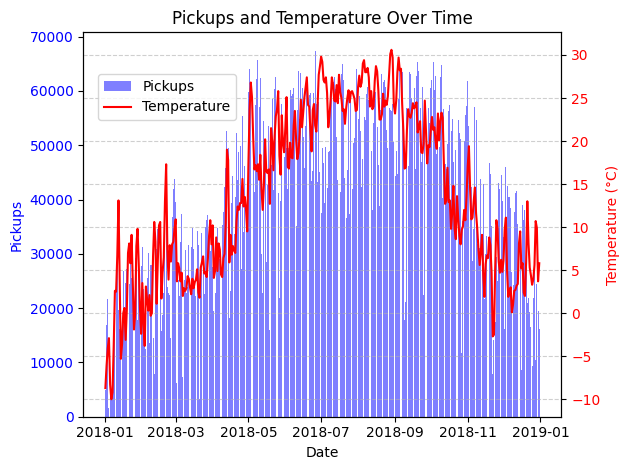

In [83]:
# Create a figure and axis
fig, ax1 = plt.subplots()

# Create a bar chart for pickups
ax1.bar(merged_data_not_standardized['date'], merged_data_not_standardized['pickups'], color='b', alpha=0.5, label='Pickups')
ax1.set_xlabel('Date')
ax1.set_ylabel('Pickups', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second axis for temperature as a line chart
ax2 = ax1.twinx()
ax2.plot(merged_data_not_standardized['date'], merged_data_not_standardized['temp'], color='r', label='Temperature')
ax2.set_ylabel('Temperature (°C)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Customize the appearance
plt.title('Pickups and Temperature Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))

# Display the graph
plt.show()

On the other hand, the irrelevance of precipitation, which scored second in terms of importance, could not be clearer.

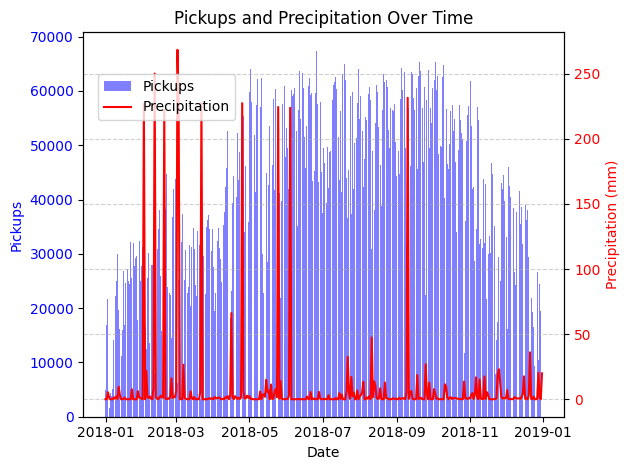

In [84]:
# Create a figure and axis
fig, ax1 = plt.subplots()

# Create a bar chart for pickups
ax1.bar(merged_data_not_standardized['date'], merged_data_not_standardized['pickups'], color='b', alpha=0.5, label='Pickups')
ax1.set_xlabel('Date')
ax1.set_ylabel('Pickups', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second axis for temperature as a line chart
ax2 = ax1.twinx()
ax2.plot(merged_data_not_standardized['date'], merged_data_not_standardized['precip'], color='r', label='Precipitation')
ax2.set_ylabel('Precipitation (mm)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Customize the appearance
plt.title('Pickups and Precipitation Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Add a legend
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.15,0.85))

# Display the graph
plt.show()

# Conclusion

To conclude, we followed the standard machine learning approarch - started with a data preparation, we removed outliers, we cleaned the data from missing values, we transformed and encoded some columns and then visualized some interesting concepts of bike rentals - how they are spread throughout the day and month and we as well looked closely at distribution of stations - where they are located.

Next we focused on clustering of the stations and looked closely at the biggest cluster. We divided the data to train set and test set and tried multiple statistical models - Linear Regression, Support Vector Regression (SVR) and Decision Tree Regressor for both pickups and drop offs predictions. We computed different metrics like RMSE, $R^{2}$ to see how the models are performing. We created a function that makes it possible to analyse and predict demand for all clusters. 

In [85]:
print("Results for pickups, drop-offs predictions.\n")
print("---------------")
evaluate("Linear Regression", "pickups", x_testing_pickup, y_testing_pickup, y_pred_p_lr, 0, False)
print("")
evaluate("Linear Regression", "dropoffs", x_testing_dropoffs, y_testing_dropoffs, y_pred_d_lr, 0, False)
print("---------------")
evaluate("SVR", "pickups", x_testing_pickup, y_testing_pickup, y_pred_p_svr, 0, False)
print("")
evaluate("SVR", "dropoffs", x_testing_dropoffs, y_testing_dropoffs, y_pred_d_svr, 0, False)
print("---------------")
evaluate("Decision Tree Regressor", "pickups", x_testing_pickup, y_testing_pickup, y_pred_p_dt, 0, False)
print("")
evaluate("Decision Tree Regressor", "dropoffs", x_testing_dropoffs, y_testing_dropoffs, y_pred_d_dt, 0, False)

Results for pickups, drop-offs predictions.

---------------
Linear Regression for pickups:
Mean Absolute Error (MAE): 17.8108
Mean Squared Error (MSE): 702.5878
Root Mean Squared Error (RMSE): 26.5064
R-squared (R^2): 0.9073

Linear Regression for dropoffs:
Mean Absolute Error (MAE): 14.6924
Mean Squared Error (MSE): 426.0740
Root Mean Squared Error (RMSE): 20.6416
R-squared (R^2): 0.9419
---------------
SVR for pickups:
Mean Absolute Error (MAE): 20.8641
Mean Squared Error (MSE): 1123.8231
Root Mean Squared Error (RMSE): 33.5235
R-squared (R^2): 0.8517

SVR for dropoffs:
Mean Absolute Error (MAE): 18.7610
Mean Squared Error (MSE): 825.7162
Root Mean Squared Error (RMSE): 28.7353
R-squared (R^2): 0.8874
---------------
Decision Tree Regressor for pickups:
Mean Absolute Error (MAE): 17.7653
Mean Squared Error (MSE): 713.2733
Root Mean Squared Error (RMSE): 26.7072
R-squared (R^2): 0.9059

Decision Tree Regressor for dropoffs:
Mean Absolute Error (MAE): 17.6503
Mean Squared Error (MSE):

Based on the metrics, we conclude that the performance of Linear Regression and Decision Tree Regressor for predicting pick-ups are very similar and close, but Linear Regression outperforms all others in predicting drop offs. 

To circle back and answer our research question:

**Is it possible to use weather data to forecast the pickups and drop-offs for a day, and if so, what factors play a crucial role in this prediction?** 

Shortly, yes, from the models mentioned above the best was Random Forest both for pickups and drop offs in predicting the bike demand. The rest did not achieve such a good results. Based on the analysis of feature importance we can say that temperature plays the key role in the prediction of bike rental demand and the other factors are not that important.


From the business point of view, the service level of bike renting can be improved when the availability of bikes fits the demand better and more accurately, our research shows that this can be achieved by using a prediction model for demands that uses the demand from previous day and/or uses temperature forecast.

# Report details

### Word counts

In [86]:
import json

with open("Notebook_V7.ipynb") as json_file:
    data = json.load(json_file)

#print(data)

wordCount = 0
for each in data['cells']:
    cellType = each['cell_type']
    if cellType == "markdown":
        content = each['source']
        for line in content:
            temp = [word for word in line.split() if "#" not in word] # we might need to filter for more markdown keywords here
            wordCount = wordCount + len(temp)
            
print("Number of words in the report:", wordCount)

Number of words in the report: 2539


### Contributions 

We worked together on all the parts so it's difficult to specify the contributions. In the table below we list who took the lead in which part: 

| Part                    | Lead | 
| ------------------------ | --- | 
| Introduction, data analysis and visualization | Natália Pohanková & Willem Aart Saly | 
| Clustering | Leonardo Debarba Bassani & Maria do Carmo Barroso Raimundo Lopes Ribeiro |
| Prediction | Florian Comte & Leonardo Debarba Bassani & Maria do Carmo Barroso Raimundo Lopes Ribeiro |
| Exploratory | Florian Comte |
| Conclusion and descriptions | Natália Pohanková & Willem Aart Saly |